In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

In [2]:
random_state=42
tf.random.set_seed(random_state)

In [3]:
data = pd.read_csv('..\\Data\\ze41_mol_desc_db_red.csv', header=0, sep=';', decimal=',')

In [4]:
col_names = data.columns
#x_cols = ['P_VSA_MR_5', 'Mor04m', 'LUMO / eV']
x_cols = ['P_VSA_MR_5', 'Mor04m', 'E1p', 'Mor22s', 'LUMO / eV']
#x_cols=['VE2_G/D', 'Eig14_EA(dm)', 'Mor31m', 'TDB04u', 'HATS1e']
#x_cols=['VE2_G/D', 'Eig14_EA(dm)', 'Mor31m']
#x_cols = ['CATS2D_04_DP', 'CATS3D_02_AP', 'Eta_betaS', 'P_VSA_LogP_4', 'VE1_B(s)']
#x_cols = ['B04[C-C]', 'CATS3D_03_DP', 'Eig11_AEA(ed)', 'J_RG', 'SpMAD_EA(ed)']
X = data[x_cols].astype('float32')
y = data[col_names[1]].astype('float32')

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=random_state)
[X_train, X_valid, y_train, y_valid] = [pd.DataFrame(x) for x in [X_train, X_valid, y_train, y_valid]]

In [6]:
scalex = MinMaxScaler(feature_range=(-1,1))
scalex.fit(X_train)
[X_train_sc, X_valid_sc] = [pd.DataFrame(scalex.transform(x), columns=X.columns) for x in [X_train, X_valid]]

In [7]:
scaley = MinMaxScaler(feature_range=(0, 1))
scaley.fit(y_train)
[y_train_sc, y_valid_sc] = [pd.DataFrame(scaley.transform(y), columns=y.columns) for y in [y_train, y_valid]]

In [8]:
model = keras.models.Sequential([
    keras.layers.Dense(50, activation='relu', input_shape=(len(x_cols),)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1)
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                300       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,541
Trainable params: 1,541
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='mean_squared_error')

In [11]:
history = model.fit(X_train_sc, y_train_sc, validation_data=(X_valid_sc, y_valid_sc), epochs=25)

Epoch 1/25
2/2 [==============================] - 0s 50ms/step - loss: 0.4494 - val_loss: 0.3406
Epoch 2/25
2/2 [==============================] - 0s 4ms/step - loss: 0.2274 - val_loss: 0.1438
Epoch 3/25
2/2 [==============================] - 0s 4ms/step - loss: 0.1206 - val_loss: 0.0928
Epoch 4/25
2/2 [==============================] - 0s 4ms/step - loss: 0.1220 - val_loss: 0.0662
Epoch 5/25
2/2 [==============================] - 0s 4ms/step - loss: 0.0864 - val_loss: 0.0283
Epoch 6/25
2/2 [==============================] - 0s 4ms/step - loss: 0.0512 - val_loss: 0.0190
Epoch 7/25
2/2 [==============================] - 0s 4ms/step - loss: 0.0426 - val_loss: 0.0214
Epoch 8/25
2/2 [==============================] - 0s 4ms/step - loss: 0.0504 - val_loss: 0.0194
Epoch 9/25
2/2 [==============================] - 0s 4ms/step - loss: 0.0483 - val_loss: 0.0120
Epoch 10/25
2/2 [==============================] - 0s 4ms/step - loss: 0.0397 - val_loss: 0.0152
Epoch 11/25
2/2 [=====================

In [12]:
m = keras.metrics.RootMeanSquaredError()

In [13]:
y_pred = model.predict(X_valid_sc)

In [14]:
m.reset_states()
m.update_state(y_valid_sc, y_pred)
rmse_valid = m.result().numpy() * 100
rmse_valid

14.429117739200592

In [15]:
y_pred = scaley.inverse_transform(y_pred)

In [16]:
y_tr_pred = model.predict(X_train_sc)

In [17]:
m.reset_states()
m.update_state(y_train_sc, y_tr_pred)
rmse_tr = m.result().numpy() * 100
rmse_tr

15.995779633522034

In [18]:
y_tr_pred = scaley.inverse_transform(y_tr_pred)

In [19]:
m_v, b_v = np.polyfit(y_valid.to_numpy()[:, 0], y_pred[:, 0], 1)
m_t, b_t = np.polyfit(y_train.to_numpy()[:, 0], y_tr_pred[:, 0], 1)

In [20]:
def f(x, m, b):
    y = [x[i]*m + b for i in range(len(x))]
    return y

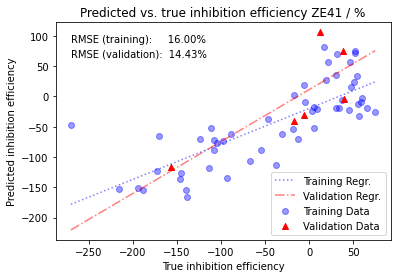

In [21]:
rng = [y.min(), y.max()]
fig, ax = plt.subplots()
ax.scatter(y_train, y_tr_pred, c='b', alpha=0.4, label='Training Data')
#ax.plot(rng,rng,'k:', alpha=0.5)
ax.plot(rng,f(rng, m_t, b_t), 'b:', alpha=0.5, label='Training Regr.')
ax.scatter(y_valid, y_pred, c='r', marker='^', label='Validation Data')
ax.plot(rng,f(rng, m_v, b_v), 'r-.', alpha=0.5, label='Validation Regr.')
#ax.text(-270, 90, 'RMSE (training):     {:.2f}%'.format(rmse_tr))
ax.text(-270, 65, 'RMSE: {:.2f}%'.format(rmse_valid))
plt.title('Predicted vs. true inhibition efficiency ZE41 / %')
plt.ylabel('Predicted inhibition efficiency')
plt.xlabel('True inhibition efficiency')
ax.legend(loc='lower right')
plt.show()

In [46]:
y_valid

,inhibition efficiency ZE41 / %
0,-157.0
5,39.0
36,12.0
45,-6.0
13,38.0
54,-17.0


In [50]:
X_s = X_valid_sc.drop([2])

In [51]:
y_s = y_valid_sc.drop([2])

In [52]:
y_pred_s = model.predict(X_s)

In [53]:
m_s, b_s = np.polyfit(y_s.to_numpy()[:, 0], y_pred_s[:, 0], 1)

In [54]:
m.reset_states()
m.update_state(y_s, y_pred_s)
rmse_valid = m.result().numpy() * 100
rmse_valid

10.099130123853683

In [55]:
y_pred_s = scaley.inverse_transform(y_pred_s)

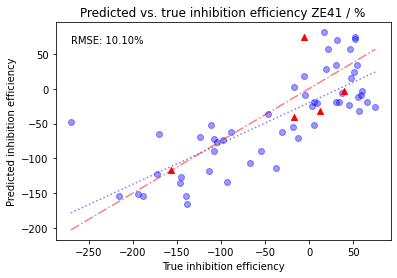

In [56]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_tr_pred, c='b', alpha=0.4, label='Training Data')
#ax.plot(rng,rng,'k:', alpha=0.5)
ax.plot(rng,f(rng, m_t, b_t), 'b:', alpha=0.5, label='Training Regr.')
ax.scatter(y_valid.drop([13]), y_pred_s, c='r', marker='^', label='Validation Data')
ax.plot(rng,f(rng, m_s, b_s), 'r-.', alpha=0.5, label='Validation Regr.')
#ax.text(-270, 90, 'RMSE (training):     {:.2f}%'.format(rmse_tr))
ax.text(-270, 65, 'RMSE: {:.2f}%'.format(rmse_valid))
plt.title('Predicted vs. true inhibition efficiency ZE41 / %')
plt.ylabel('Predicted inhibition efficiency')
plt.xlabel('True inhibition efficiency')
#ax.legend(loc='lower right')
plt.show()

In [47]:
y_valid

,inhibition efficiency ZE41 / %
0,-157.0
5,39.0
36,12.0
45,-6.0
13,38.0
54,-17.0


In [49]:
y_pred

array([[-116.03913  ],
       [  -3.9239671],
       [ 105.80158  ],
       [ -31.515427 ],
       [  74.84429  ],
       [ -40.259933 ]], dtype=float32)